## Backprojection Using Measured Antenna Characteristics
### Angle of Arrival

To check if the measured weights can be used, an image slice at the range of the reflector is generated with them.
The image intensity is calculated as
$$
I(r,\theta) = \sum_{k=0}^{K-1}g^*_{\text{meas},k}(\theta) \sum_{m=0}^{M-1}e^{+j\beta\tau_k(r,\theta)mT_s}y_k(m)
$$
In matrix notation 
($\mathbf g \in \mathbb C^K, \mathbf Y,\mathbf E \in \mathbb C^{K\times M} $ and $ \mathbf 1 \in \mathbb C^{M}$):
$$
I(r,\theta) = \mathbf g_\text{meas}^H (\mathbf Y \odot \mathbf E(r,\theta)) \mathbf 1, 
\text{where }
\mathbf E_{km} = e^{+j\beta\tau_k(r,\theta)mT_s}, \mathbf 1_m = 1
$$

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter, FuncFormatter
import torch, pickle, numpy


# setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
nfft = 2**18
pi = 3.141592653589 
maxdist = 50
lightspeed = 299_792_458 
f_start, f_end = 76_010_000_056.0, 80_289_505_280.0
t_start, t_end =  2e-6, 66.1e-6
# ramp_slope = (f_start-f_end) / (t_start-t_end)
ramp_slope = 65_950.2e9
hertz_per_meter = ramp_slope / lightspeed
print(f_start-f_end)
bins_per_meter = nfft / maxdist
fs = 22e6
Ts = 1/fs
beta = 2*pi*ramp_slope

folder = '/home/dgotzens/scripts/2.2_antenna-characteristics/measured/'
dists = [2.143, 8.099, 18.016, 32.284]

angles = [pickle.load(open(folder+f'a{int(dist):02d}_angle.pkl', 'rb')) for dist in dists]
degs = [list(map(lambda a : round(a*180/pi - 90), angle)) for angle in angles]
l_degs = [[deg.index(a) for a in sorted(set(deg)) if -60<a<60] for deg in degs]
l_sels = [[l for l,a in enumerate(angle) if -50<180/pi*a-90<50] for angle in angles]
angles_filtered = [[angle[l] for l in l_deg] for angle,l_deg in zip(angles,l_degs)]
#angles_filtered = [[angle[l] for l in l_sel] for angle,l_sel in zip(angles,l_sels)]
params = pickle.load(open(folder+'feparams.pkl', 'rb'))
tx,ty,rx,ry = params['txPosX'], params['txPosY'], params['rxPosX'], params['rxPosY']

folder = '/home/dgotzens/scripts/3.1_imaging/measured_gains/'
with open(folder+'gains.pkl', 'rb') as f:
    gains = pickle.load(f)
with open(folder+'taus.pkl', 'rb') as f:
    taus = pickle.load(f)

cuda:0
-4279505224.0


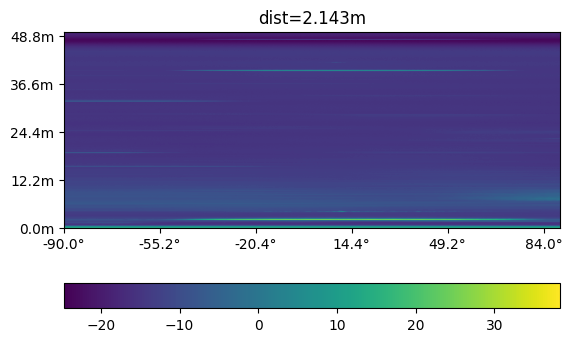

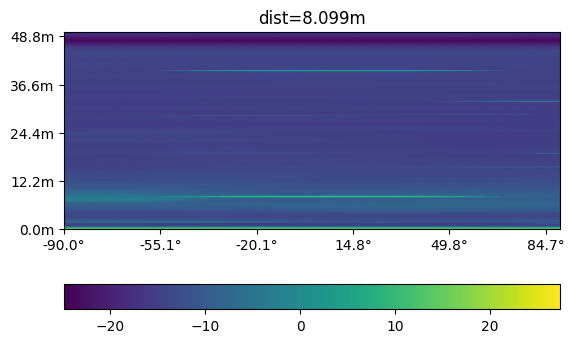

In [3]:
for n in range(2):
    dist = dists[n]
    angle = angles[n]
    l_deg = l_degs[n]
    gain = gains[n]
    folder = '/home/dgotzens/recording/'
    data = torch.load(folder+f'a{int(dist):02d}_data.pt')
    M,K,L = data.shape

    plt.imshow(20*torch.fft.fft(torch.hann_window(M)[:,None,None]*data[:,:,:], n=2048, dim=0).abs().mean(1).log10(), origin='lower')
    plt.colorbar(orientation='horizontal')
    plt.title(f'dist={dist}m')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x,pos : f'{x/2048*maxdist:.1f}m'))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x,pos : f'{x/L*180-90:.1f}°'))
    plt.show()

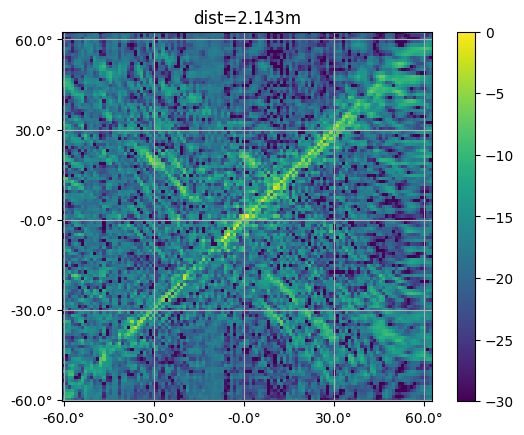

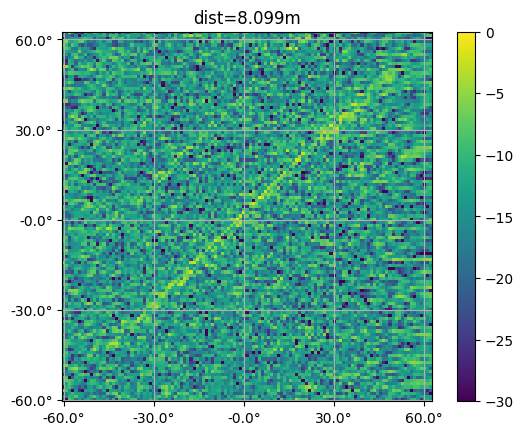

In [36]:
for n in range(2):
    dist = dists[n]
    angle = angles_filtered[n]
    l_deg = l_degs[n]
    gain = gains[n]
    folder = '/home/dgotzens/recording/'
    data = torch.load(folder+f'a{int(dist):02d}_data.pt')[:,:,l_deg]
    M,K,L = data.shape
    tau = taus[n].unflatten(0,(K,L))

    img = (gain[None,:,None,:].conj() * data[:,:,:,None] * torch.exp(1j*beta*tau[None,:,None,:] * torch.arange(M)[:,None,None,None] * Ts)).sum((0,1))
    #img = (gain[None,:,None,:].conj() * data[:,:,:,None]/(data.abs().mean(2)[:,:,None,None]+0.001) * torch.exp(1j*beta*tau[None,:,None,:] * torch.arange(M)[:,None,None,None] * Ts)).sum((0,1))
    img /= img.abs().mean(0)
    plt.imshow(20*img.abs().log10() - 20*img.abs().log10().max(), origin='lower', vmin=-30)
    plt.colorbar(orientation='vertical')
    plt.xticks(range(0,L, L//4), [f'{round(180/pi*angle[l]-90,-1)}°' for l in range(0,L, L//4)])
    plt.yticks(range(0,L, L//4), [f'{round(180/pi*angle[l]-90,-1)}°' for l in range(0,L, L//4)])
    plt.title(f'dist={dist}m')
    plt.grid()
    plt.show()

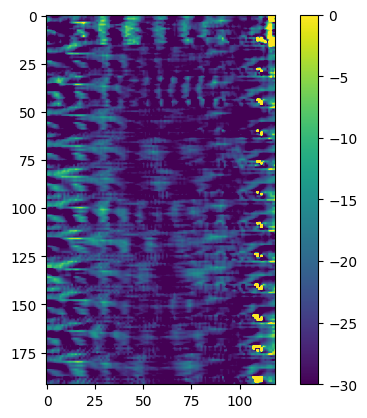

In [57]:
plt.imshow((taus[0].unflatten(0,(K,L)) - tau[:,:,R//2])*lightspeed/2*1000, vmin=-30,vmax=0)
plt.colorbar()